In [1]:
# -*- coding: utf-8 -*-

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt


env = gym.make('CartPole-v1')
env.reset(seed=0)
torch.manual_seed(0)
GAMMA = 0.95

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

    
################################################
# Replay Buffer (not necessary)
################################################

# store trajectories to a buffer
class ReplayBuffer:
    def __init__(self, state_dim, action_dim):
        # use lists as a buffer for CartPole-v1
        # because an episode of CartPole may be extreamly long 
        
        # record transition (s, a, r, s', terminated)
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.terminateds = []
        
        # discounted returns 
        self.returns = []
        
        # whether or not updating the network paramters is ready
        self.is_ready = False # True if returns are calculated
        
    def add(self, state, action, reward, next_state, terminated):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.terminateds.append(terminated)
    
    def get(self):
        
        data = { 
            # convert lists into numpy arrays
            'states': np.array(self.states),
            'actions': np.array(self.actions),
            'rewards': np.array(self.rewards),
            'next_states': np.array(self.next_states),
            'terminateds': np.array(self.terminateds),
            'returns': np.array(self.returns)
            }
        
        return data
    
    def clear(self):
        del self.states[:]
        del self.states[:] 
        del self.actions[:] 
        del self.rewards[:] 
        del self.next_states[:]
        del self.terminateds[:]
        # del self.returns[:]
    
    def get_ready(self):
        self.is_ready = True

    def __len__(self):
        return len(self.states)
    
    def __repr__(self):
        return 'buffer'
    
    


In [2]:
#####################################################
# policy 
#####################################################
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(Policy, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, action_dim)
            )

    def forward(self, x:torch.Tensor):
        action_scores = self.layers(x)
        pi = F.softmax(action_scores, dim=1) # probabilities
        return pi



In [3]:
##############################################
# policy gradient method (Reinforce)
#=============================================
class Reinforce():
    def __init__(self,state_dim, action_dim, normalize_returns=True):
        self.policy = Policy(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=0.01)
        self.buffer = ReplayBuffer(state_dim, action_dim)
        self.normalize_returns = normalize_returns 
        self.max_steps = 99999 # prevent an extreamly long episode
        self.total_steps = 0
    
    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device) # convert state into 2D float32 tensor
        probabilities = self.policy(state)
        distribution = Categorical(probabilities)
        action = distribution.sample()
        
        return action.item()
    
    def collect_episodes(self, num_episodes: int) -> list:
        episode_rewards = []
        for i in range(num_episodes):
            state, _ = env.reset()
            episode_reward = 0
            for t in range(1, self.max_steps): 
                action = self.select_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                self.total_steps += 1
                
                # add data to buffer
                self.buffer.add(state, action, reward, next_state, terminated)
                
                if terminated:
                    break
                
                # prepare next step
                state = next_state
                episode_reward += 1
                
            episode_rewards.append(episode_reward)
        
        return episode_rewards
    
    def compute_returns(self):
        # retrieve data from the buffer
        data = self.buffer.get()
        rewards = data['rewards']
        terminateds = data['terminateds']
        
        # compute discounted returns for N episodes
        returns = []
        ret = 0 # discounted return
        for i in reversed(range(len(rewards))):
            if terminateds[i]:
                ret = rewards[i]
            else:
                ret = rewards[i] + GAMMA * ret
            
            returns.insert(0, ret)
        
        # normalize returns across N episodes
        if self.normalize_returns:
            returns = np.array(returns)
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        # add returns to the buffer
        self.buffer.returns = np.array(returns)
        
        # buffer is ready to compute the loss of the policy
        self.buffer.get_ready()
        
    
    # update policy
    def update(self):        
        # compute discounted returns
        self.compute_returns()
        
        # get data from the buffer
        data = self.buffer.get()
        states = data['states']
        actions = data['actions']
        terminateds = data['terminateds']
        returns = data['returns']
        
        # numpy array to tensor
        states = torch.from_numpy(states).float().to(device) # linear support toch.float32
        actions = torch.tensor(actions).to(device)
        returns = torch.tensor(returns).to(device)
        
        # number of episodes we collected
        num_episodes = terminateds.sum()
        
        # compute the loss of the policy 
        probabilities = self.policy(states)
        distributions = Categorical(probabilities)
        log_probs = distributions.log_prob(actions)
        loss = (-log_probs * returns).sum() / num_episodes
        
        # update
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # clear
        self.buffer.clear()
        

  10 Episode |     178 Totalsteps | Avg reward= 16.8 
  20 Episode |     410 Totalsteps | Avg reward= 22.2 
  30 Episode |     665 Totalsteps | Avg reward= 24.5 
  40 Episode |    1144 Totalsteps | Avg reward= 46.9 
  50 Episode |    1649 Totalsteps | Avg reward= 49.5 
  60 Episode |    2346 Totalsteps | Avg reward= 68.7 
  70 Episode |    2970 Totalsteps | Avg reward= 61.4 
  80 Episode |    3981 Totalsteps | Avg reward=100.1 
  90 Episode |    5059 Totalsteps | Avg reward=106.8 
 100 Episode |    6402 Totalsteps | Avg reward=133.3 
******************************
 110 Episode |    8469 Totalsteps | Avg reward=205.7 
 120 Episode |   10440 Totalsteps | Avg reward=196.1 
 130 Episode |   12633 Totalsteps | Avg reward=218.3 
 140 Episode |   14498 Totalsteps | Avg reward=185.5 
 150 Episode |   15689 Totalsteps | Avg reward=118.1 
 160 Episode |   17293 Totalsteps | Avg reward=159.4 
 170 Episode |   18974 Totalsteps | Avg reward=167.1 
 180 Episode |   20595 Totalsteps | Avg reward=161.

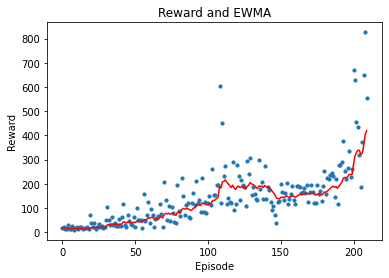

In [4]:
# plot rewards and Exponential Weighted Moving Averages
def plot(rewards):
    fig, ax = plt.subplots()

    # Scatter plot of rewards
    ax.scatter(range(len(rewards)), rewards, s=10)  # Set s=10 to make points smaller
    
    # Calculate the EWMA of rewards
    alpha = 0.1  # Adjust the alpha value for the desired smoothing effect
    emwa_rewards = np.zeros_like(rewards)
    emwa_rewards[0] = rewards[0]  # Initialize the first value
    for i in range(1, len(rewards)):
        emwa_rewards[i] = alpha * rewards[i] + (1 - alpha) * emwa_rewards[i-1]
    
    # Plot EMWA of rewards
    ax.plot(range(len(emwa_rewards)), emwa_rewards, color='red')
    
    # Set labels and title
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.set_title('Reward and EWMA')
    
    # Show the plot
    plt.show()

# main
def main(): 
    global env
    global device
    
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    # create reinforce obj
    reinforce = Reinforce(state_dim, action_dim)
    
    # record reward for each episode
    episode_rewards = []

    # training
    num_episodes = 10 # compute loss during 10 episodes
    for i in range(1, 1000): 
        # collect N episodes
        batch_rewards = reinforce.collect_episodes(num_episodes)
        
        # record episode rewards
        episode_rewards.extend(batch_rewards)
        
        # compute the loss andd update the policy
        reinforce.update()
        
        # print message
        avg_reward = np.array(batch_rewards).mean()
        total_steps = reinforce.total_steps
        print("{:4d} Episode | {:7d} Totalsteps | Avg reward={:5.1f} " 
              .format(i*num_episodes, total_steps, avg_reward))
        
        if i % 10 == 0:
            print("*" * 30)
            
        if avg_reward > 500:
            print("Solved!")
            break
    
    # plot the episode rewards
    plot(episode_rewards)
            
if __name__ == '__main__':
    main()